<img src="../assets/packt-banner.png" alt="">

# Chapter 6: Web Scraping with Jupyter Notebooks

We use HTTP requests to pull data from the web, using both APIs and web scraping. Then we create a dataset from the results, and explore it.

---

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")

In [2]:
%load_ext watermark
%watermark -d -v -m -p requests,numpy,pandas,matplotlib,seaborn,sklearn

2020-07-20 

CPython 3.7.6
IPython 7.10.1

requests 2.22.0
numpy 1.17.4
pandas 0.25.3
matplotlib 3.1.1
seaborn 0.9.0
sklearn 0.22

compiler   : GCC 7.5.0
system     : Linux
release    : 4.15.0-96-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


---

## Scraping web-page data    

---

### Introduction to HTTP requests

---

In [3]:
import requests

In [4]:
# Set up request header

url = 'https://jupyter.org/'
req = requests.Request('GET', url)
req = req.prepare()

In [5]:
req?

In [6]:
# Make the request

with requests.Session() as sess:
    resp = sess.send(req)

In [7]:
resp

<Response [200]>

In [8]:
resp.status_code

200

In [9]:
page_html = resp.text

In [10]:
page_html[:1000]

'<!DOCTYPE html>\n<html>\n\n  <head>\n\n    <meta charset="utf-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    <meta name="description" content="">\n    <meta name="author" content="">\n\n    <title>Project Jupyter | Home</title>\n    <meta property="og:title" content="Project Jupyter" />\n    <meta property="og:description" content="The Jupyter Notebook is a web-based interactive computing platform. The notebook combines live code, equations, narrative text, visualizations, interactive dashboards and other media.\n">\n    <meta property="og:url" content="https://www.jupyter.org" />\n    <meta property="og:image" content="https://jupyter.org/assets/homepage.png" />\n    <!-- Bootstrap Core CSS -->\n    <link rel="stylesheet" href="/css/bootstrap.min.css">\n    <link rel="stylesheet" href="/css/logo-nav.css?1594832988204333248">\n    <link rel="stylesheet" href="/css/cardlist.css">\n    <link r

In [11]:
from bs4 import BeautifulSoup
print(BeautifulSoup(page_html, 'html.parser').prettify()[:1000])

<!DOCTYPE html>
<html>
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta content="" name="description"/>
  <meta content="" name="author"/>
  <title>
   Project Jupyter | Home
  </title>
  <meta content="Project Jupyter" property="og:title">
   <meta content="The Jupyter Notebook is a web-based interactive computing platform. The notebook combines live code, equations, narrative text, visualizations, interactive dashboards and other media.
" property="og:description"/>
   <meta content="https://www.jupyter.org" property="og:url">
    <meta content="https://jupyter.org/assets/homepage.png" property="og:image">
     <!-- Bootstrap Core CSS -->
     <link href="/css/bootstrap.min.css" rel="stylesheet"/>
     <link href="/css/logo-nav.css?1594832988204333248" rel="stylesheet"/>
     <link href="/css/cardlist.css" rel="stylesheet"/>
     <link href="/css/github-buttons.cs

In [12]:
from IPython.display import HTML
HTML(page_html)

In [13]:
url

'https://jupyter.org/'

In [14]:
from IPython.display import IFrame
IFrame(src=url, height=800, width=800)

In [15]:
# Easier way to make a GET request

url = 'http://www.python.org/'
resp = requests.get(url)
resp

<Response [200]>

In [16]:
resp.url

'https://www.python.org/'

In [17]:
resp.history

[<Response [301]>]

---

### Using basic web APIs
---

In [18]:
# Define wiki API URL

url = (
    'https://en.wikipedia.org/w/api.php'
    '?action=parse'
    '&page=List_of_countries_by_central_bank_interest_rates'
    '&section=1'
    '&prop=wikitext'
    '&format=json'
)
url

'https://en.wikipedia.org/w/api.php?action=parse&page=List_of_countries_by_central_bank_interest_rates&section=1&prop=wikitext&format=json'

In [19]:
# Make API request

resp = requests.get(url)
resp

<Response [200]>

In [20]:
# Note the JSON format

resp.text[:100]

'{"parse":{"title":"List of countries by central bank interest rates","pageid":20582369,"wikitext":{"'

In [21]:
data = resp.json()
type(data)

dict

In [22]:
data

{'parse': {'title': 'List of countries by central bank interest rates',
  'pageid': 20582369,
  'wikitext': {'*': '== List ==\n{| class="wikitable sortable" style="text-align: center;"\n|- bgcolor="#ececec" valign=bottom\n! Country or<br>currency union !! Central bank <br> interest rate (%) !! Date of last <br> change\n! Average inflation rate 2013-2017 (%)\nby [[World Bank|WB]] and [[International Monetary Fund|IMF]]<ref>{{Cite web|url=https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?end=2017&start=1986&year_high_desc=false|title=Inflation, consumer prices (annual %) {{!}} Data|website=data.worldbank.org|access-date=2019-12-07}}</ref><ref>{{Cite web|url=https://www.imf.org/external/pubs/ft/weo/2018/02/weodata/weorept.aspx?pr.x=28&pr.y=13&sy=2017&ey=2017&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512,213,626,628,636,453,643,646,648,732,923,299,474&s=PCPIPCH&grp=0&a=|title=Report for Selected Countries and Subjects|website=www.imf.org|access-date=2019-12-07}}</ref> as in the [[List of cou

In [23]:
# The page title

data['parse']['title']

'List of countries by central bank interest rates'

In [24]:
# Look a random row from the table

row_idx = 16

wikitext = data['parse']['wikitext']['*']
table_row = wikitext.split('|-')[row_idx]
table_row

'                \n|align="left"| {{flag|Canada}} || 0.25 || {{dts|format=dmy|2020-03-27}}<ref name="CentralBankNews"/><ref name="GlobalRates">{{Cite web|url=http://www.global-rates.com/interest-rates/central-banks/central-banks.aspx|title=Central banks - summary of current interest rates|work=global-rates.com|accessdate=13 July 2017}}</ref>\n|1.40\n|0.35\n|1.25\n'

In [25]:
# Parse the country

import re
re.findall('flag\|([^}]+)}', table_row)

['Canada']

In [26]:
# Parse the interest rate

table_row.split('||')[1].strip()

'0.25'

---

### Parsing HTML with Python   

---

In [27]:
# Request the Wiki page

url = 'https://en.wikipedia.org/wiki/List_of_countries_by_central_bank_interest_rates'
resp = requests.get(url)
print(resp.url, resp.status_code)

https://en.wikipedia.org/wiki/List_of_countries_by_central_bank_interest_rates 200


In [28]:
# Load the HTML as a Beautiful Soup object

from bs4 import BeautifulSoup
soup = BeautifulSoup(resp.content, 'html.parser')

In [29]:
soup?

In [30]:
# Inspect the soup object with dir

dir(soup)

['ASCII_SPACES',
 'DEFAULT_BUILDER_FEATURES',
 'NO_PARSER_SPECIFIED_WARNING',
 'ROOT_TAG_NAME',
 '__bool__',
 '__call__',
 '__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_all_strings',
 '_check_markup_is_url',
 '_feed',
 '_find_all',
 '_find_one',
 '_is_xml',
 '_lastRecursiveChild',
 '_last_descendant',
 '_linkage_fixer',
 '_most_recent_element',
 '_namespaces',
 '_popToTag',
 '_should_pretty_print',
 'append',
 'attrs',
 'builder',
 'can_be_empty_element',
 'cdata_list_attributes',
 'childGenerator',
 'children',
 'cl

In [31]:
# Inspect the soup object with pdir2
# pip install pdir2

import pdir
pdir(soup)

property:
    ASCII_SPACES, DEFAULT_BUILDER_FEATURES, NO_PARSER_SPECIFIED_WARNING, ROOT_TAG_NAME, _most_recent_element, _namespaces, attrs, builder, can_be_empty_element, cdata_list_attributes, contains_replacement_characters, contents, currentTag, current_data, declared_html_encoding, element_classes, hidden, is_xml, known_xml, markup, name, namespace, next_element, next_sibling, original_encoding, parent, parse_only, prefix, preserve_whitespace_tag_stack, preserve_whitespace_tags, previous_element, previous_sibling, tagStack
special attribute:
    __class__, __dict__, __doc__, __module__, __weakref__
abstract class:
    __subclasshook__
object customization:
    __bool__, __format__, __hash__, __init__, __new__, __repr__, __sizeof__, __str__
rich comparison:
    __eq__, __ge__, __gt__, __le__, __lt__, __ne__
attribute access:
    __delattr__, __dir__, __getattr__, __getattribute__, __setattr__
class customization:
    __init_subclass__
container:
    __contains__, __delitem__, __geti

In [32]:
# What is the primary heading tag(s)?

h1 = soup.find_all('h1')
h1

[<h1 class="firstHeading" id="firstHeading" lang="en">List of countries by central bank interest rates</h1>]

In [33]:
# Pick out first list element
h1 = h1[0]

In [34]:
# Print the HTML element attributes
h1.attrs

{'id': 'firstHeading', 'class': ['firstHeading'], 'lang': 'en'}

In [35]:
# Get the visible text
h1.text

'List of countries by central bank interest rates'

In [36]:
# Get the images on the page

imgs = soup.find_all('img')
len(imgs)

93

In [37]:
# Print the image source URIs

for element in imgs:
    if 'src' in element.attrs.keys():
        print(element.attrs['src'])

//upload.wikimedia.org/wikipedia/commons/thumb/3/36/Flag_of_Albania.svg/21px-Flag_of_Albania.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Flag_of_Angola.svg/23px-Flag_of_Angola.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Flag_of_Argentina.svg/23px-Flag_of_Argentina.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Flag_of_Armenia.svg/23px-Flag_of_Armenia.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/8/88/Flag_of_Australia_%28converted%29.svg/23px-Flag_of_Australia_%28converted%29.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Flag_of_Azerbaijan.svg/23px-Flag_of_Azerbaijan.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/9/93/Flag_of_the_Bahamas.svg/23px-Flag_of_the_Bahamas.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Flag_of_Bahrain.svg/23px-Flag_of_Bahrain.svg.png
//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/23px-Flag_of_Bangladesh.svg.png
//upload.wikimedia.org/wikipedia/

In [38]:
# Get the body content div
body_content = soup.find('div', {'id': 'bodyContent'})

In [39]:
# Get the table headers

table_headers = body_content.find_all('th')
table_headers

[<th>Country or<br/>currency union</th>,
 <th>Central bank <br/> interest rate (%)</th>,
 <th>Date of last <br/> change
 </th>,
 <th>Average inflation rate 2013-2017 (%)
 <p>by <a href="/wiki/World_Bank" title="World Bank">WB</a> and <a href="/wiki/International_Monetary_Fund" title="International Monetary Fund">IMF</a><sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup><sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup> as in the <a href="/wiki/List_of_countries_by_inflation_rate" title="List of countries by inflation rate">List</a>
 </p>
 </th>,
 <th>Central bank interest rate <br/> minus <br/> average inflation rate (2013-2017)
 </th>,
 <th>Central bank interest rate <br/> divided by <br/> average inflation rate (2013-2017)
 </th>,
 <th class="navbox-title" colspan="2" scope="col"><div class="plainlinks hlist navbar mini"><ul><li class="nv-view"><a href="/wiki/Template:Finance_country_lists" title="Template:Finance country lists"><abbr 

In [40]:
# Get the text

for i, t in enumerate(table_headers):
    print(i, t.text.strip())
    print('-'*10)

0 Country orcurrency union
----------
1 Central bank  interest rate (%)
----------
2 Date of last  change
----------
3 Average inflation rate 2013-2017 (%)
by WB and IMF[1][2] as in the List
----------
4 Central bank interest rate  minus  average inflation rate (2013-2017)
----------
5 Central bank interest rate  divided by  average inflation rate (2013-2017)
----------
6 vteLists of countries by financial rankings
----------
7 Trade
----------
8 Investment
----------
9 Funds
----------
10 Budget and debt
----------
11 Income and taxes
----------
12 Bank rates
----------
13 Currency
----------
14 Other
----------
15 vteLists of countries by public policy topics
----------
16 General
----------
17 Economic
----------
18 Health
----------
19 Social
----------


In [41]:
# Manually set the headers

table_headers = [
    'Country or currency union',
    'Central bank interest rate (%)',
    'Date of last change',
    'Average inflation rate (%)'
]

In [42]:
# Get the data for a sample row

row_number = 8
row_data = body_content.find_all('tr')[row_number]\
                .find_all('td')

In [43]:
row_data

[<td align="left"><span class="flagicon"><img alt="" class="thumbborder" data-file-height="900" data-file-width="1500" decoding="async" height="14" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Flag_of_Bahrain.svg/23px-Flag_of_Bahrain.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Flag_of_Bahrain.svg/35px-Flag_of_Bahrain.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Flag_of_Bahrain.svg/46px-Flag_of_Bahrain.svg.png 2x" width="23"/> </span><a href="/wiki/Bahrain" title="Bahrain">Bahrain</a></td>,
 <td>2.50</td>,
 <td><span data-sort-value="000000002019-07-31-0000" style="white-space:nowrap">31 July 2019</span><sup class="reference" id="cite_ref-CentralBankNews_3-6"><a href="#cite_note-CentralBankNews-3">[3]</a></sup>
 </td>,
 <td>2.40
 </td>,
 <td>0.10
 </td>,
 <td>1.04
 </td>]

In [44]:
for i, d in enumerate(row_data):
    print(i, d.text)

0  Bahrain
1 2.50
2 31 July 2019[3]

3 2.40

4 0.10

5 1.04



In [45]:
d1 = row_data[0]
d1

<td align="left"><span class="flagicon"><img alt="" class="thumbborder" data-file-height="900" data-file-width="1500" decoding="async" height="14" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Flag_of_Bahrain.svg/23px-Flag_of_Bahrain.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Flag_of_Bahrain.svg/35px-Flag_of_Bahrain.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Flag_of_Bahrain.svg/46px-Flag_of_Bahrain.svg.png 2x" width="23"/> </span><a href="/wiki/Bahrain" title="Bahrain">Bahrain</a></td>

In [46]:
d1.text

'\xa0Bahrain'

In [47]:
d1.find('a')

<a href="/wiki/Bahrain" title="Bahrain">Bahrain</a>

In [48]:
d1.find('a').text

'Bahrain'

In [49]:
d2 = row_data[1]
d2

<td>2.50</td>

In [50]:
d2.text

'2.50'

In [51]:
d3 = row_data[2]
d3

<td><span data-sort-value="000000002019-07-31-0000" style="white-space:nowrap">31 July 2019</span><sup class="reference" id="cite_ref-CentralBankNews_3-6"><a href="#cite_note-CentralBankNews-3">[3]</a></sup>
</td>

In [52]:
d3.text

'31 July 2019[3]\n'

In [53]:
d3.find_all('span')

[<span data-sort-value="000000002019-07-31-0000" style="white-space:nowrap">31 July 2019</span>]

In [54]:
d3.find_all('span')[0].text

'31 July 2019'

In [55]:
d4 = row_data[3]
d4

<td>2.40
</td>

In [56]:
d4.text

'2.40\n'

In [57]:
d4.text.strip()

'2.40'

In [58]:
# Perform the full scrape by iterating over the rows

int_rates_data = []
row_elements = body_content.find_all('tr')
for i, row in enumerate(row_elements):
    row_data = row.find_all('td')
    if len(row_data) < 4:
        print('Ignoring row {} because length < 4'.format(i))
        continue
        
    d1, d2, d3, d4 = row_data[:4]
    errs = []
    
    try:
        d1 = d1.find('a').text
    except Exception as e:
        d1 = ''
        errs.append(str(e))

    try:
        d2 = d2.text
    except Exception as e:
        d2 = ''
        errs.append(str(e))
        
    try:
        d3 = d3.find_all('span')[0].text
    except Exception as e:
        d3 = ''
        errs.append(str(e))
        
    try:
        d4 = d4.text.strip()
    except Exception as e:
        d4 = ''
        errs.append(str(e))

    data = [d1, d2, d3, d4]
    print(data)
    int_rates_data.append(data)
        
    if errs:
        print('Errors in row {}: {}'.format(i, ', '.join(errs)))

Ignoring row 0 because length < 4
['Albania', '1.00', '6 June 2016', '1.75']
['Angola', '15.50', '24 May 2019', '17.54']
['Argentina', '38.00', '5 March 2020', '31.17']
['Armenia', '5.75', '29 January 2019', '2.38']
['Australia', '0.25', '19 March 2020', '1.93']
['Azerbaijan', '7.25', '1 May 2020', '6.51']
['Bahamas', '4.00', '22 December 2016', '0.97']
['Bahrain', '2.50', '31 July 2019', '2.40']
['Bangladesh', '6.00', '6 April 2018', '6.38']
['Barbados', '7.00', '1 June 2009', '1.67']
['Belarus', '9.50', '7 August 2019', '13.47']
['Botswana', '5.00', '24 October 2017', '3.89']
['Brazil', '2.25', '17 June 2020', '6.73']
['Bulgaria', '0.00', '29 January 2016', '0.12']
['Canada', '0.25', '27 March 2020', '1.40']
['Cape Verde', '5.50', '7 June 2017', '0.15']
['Central African States', '2.95', '22 March 2017', '']
['Chile', '1.75', '23 October 2019', '3.30']
['China', '4.20', '20 September 2019', '1.93']
['Czech Republic', '0.25', '11 May 2020', '1.04']
['Colombia', '4.25', '27 April 2018'

In [59]:
bad_row_26 = body_content.find_all('tr')[26]

In [60]:
d1, d2, d3, d4 = bad_row_26.find_all('td')[:4]

In [61]:
d1.find('a').text

'Eastern Caribbean'

In [62]:
float(d2.text)

6.5

In [63]:
#d3.find_all('span')[0].text

In [64]:
d3.find_all('span')

[]

In [65]:
# Recall the relevant table headers

table_headers

['Country or currency union',
 'Central bank interest rate (%)',
 'Date of last change',
 'Average inflation rate (%)']

In [66]:
# What data did we pull?

int_rates_data

[['Albania', '1.00', '6 June 2016', '1.75'],
 ['Angola', '15.50', '24 May 2019', '17.54'],
 ['Argentina', '38.00', '5 March 2020', '31.17'],
 ['Armenia', '5.75', '29 January 2019', '2.38'],
 ['Australia', '0.25', '19 March 2020', '1.93'],
 ['Azerbaijan', '7.25', '1 May 2020', '6.51'],
 ['Bahamas', '4.00', '22 December 2016', '0.97'],
 ['Bahrain', '2.50', '31 July 2019', '2.40'],
 ['Bangladesh', '6.00', '6 April 2018', '6.38'],
 ['Barbados', '7.00', '1 June 2009', '1.67'],
 ['Belarus', '9.50', '7 August 2019', '13.47'],
 ['Botswana', '5.00', '24 October 2017', '3.89'],
 ['Brazil', '2.25', '17 June 2020', '6.73'],
 ['Bulgaria', '0.00', '29 January 2016', '0.12'],
 ['Canada', '0.25', '27 March 2020', '1.40'],
 ['Cape Verde', '5.50', '7 June 2017', '0.15'],
 ['Central African States', '2.95', '22 March 2017', ''],
 ['Chile', '1.75', '23 October 2019', '3.30'],
 ['China', '4.20', '20 September 2019', '1.93'],
 ['Czech Republic', '0.25', '11 May 2020', '1.04'],
 ['Colombia', '4.25', '27 Apri

In [67]:
# Save data to a CSV file

f_path = '../data/countries/interest_rates_raw.csv'
pd.DataFrame(int_rates_data, columns=table_headers)\
    .to_csv(f_path, index=False)

In [68]:
%%bash
head ../data/countries/interest_rates_raw.csv

Country or currency union,Central bank interest rate (%),Date of last change,Average inflation rate (%)
Albania,1.00,6 June 2016,1.75
Angola,15.50,24 May 2019,17.54
Argentina,38.00,5 March 2020,31.17
Armenia,5.75,29 January 2019,2.38
Australia,0.25,19 March 2020,1.93
Azerbaijan,7.25,1 May 2020,6.51
Bahamas,4.00,22 December 2016,0.97
Bahrain,2.50,31 July 2019,2.40
Bangladesh,6.00,6 April 2018,6.38


---

### Activity: Web Scraping with Python   

---

In [69]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'

_Note: If desired, the following code can be removed from the student version of the notebook and replaced with empty cells._

---

In [70]:
# Check out the page
from IPython.display import IFrame
IFrame(url, height=300, width=800)

In [71]:
# Request the page

resp = requests.get(url)
resp

<Response [200]>

In [72]:
# Instantiate Beautiful Soup object

soup = BeautifulSoup(resp.content, 'html.parser')

In [73]:
# Get the H1

soup.find_all('h1')

[<h1 class="firstHeading" id="firstHeading" lang="en">List of countries and dependencies by population</h1>]

In [74]:
# Get the body content div

body_content = soup.find('div', {'id': 'bodyContent'})

In [75]:
# Get the table headers

table_headers = body_content.find_all('th')
table_headers

[<th data-sort-type="number">Rank</th>,
 <th>Country (or dependent territory)</th>,
 <th>Population</th>,
 <th>% of world<br/>population</th>,
 <th>Date</th>,
 <th class="unsortable">Source
 </th>,
 <th>1
 </th>,
 <th>2
 </th>,
 <th>3
 </th>,
 <th>4
 </th>,
 <th>5
 </th>,
 <th>6
 </th>,
 <th>7
 </th>,
 <th>8
 </th>,
 <th>9
 </th>,
 <th>10
 </th>,
 <th>11
 </th>,
 <th>12
 </th>,
 <th>13
 </th>,
 <th>14
 </th>,
 <th>15
 </th>,
 <th>16
 </th>,
 <th>17
 </th>,
 <th>18
 </th>,
 <th>19
 </th>,
 <th>20
 </th>,
 <th>21
 </th>,
 <th>22
 </th>,
 <th>23
 </th>,
 <th>24
 </th>,
 <th>25
 </th>,
 <th>26
 </th>,
 <th>27
 </th>,
 <th>28
 </th>,
 <th>29
 </th>,
 <th>30
 </th>,
 <th>31
 </th>,
 <th>32
 </th>,
 <th>33
 </th>,
 <th>34
 </th>,
 <th>35
 </th>,
 <th>36
 </th>,
 <th>37
 </th>,
 <th>38
 </th>,
 <th>39
 </th>,
 <th>40
 </th>,
 <th>41
 </th>,
 <th>42
 </th>,
 <th>43
 </th>,
 <th>44
 </th>,
 <th>45
 </th>,
 <th>46
 </th>,
 <th>47
 </th>,
 <th>48
 </th>,
 <th>49
 </th>,
 <th>50
 </th>,
 <th>51
 </

In [76]:
for i, t in enumerate(table_headers):
    print(i, t.text.strip())
    print('-'*10)

0 Rank
----------
1 Country (or dependent territory)
----------
2 Population
----------
3 % of worldpopulation
----------
4 Date
----------
5 Source
----------
6 1
----------
7 2
----------
8 3
----------
9 4
----------
10 5
----------
11 6
----------
12 7
----------
13 8
----------
14 9
----------
15 10
----------
16 11
----------
17 12
----------
18 13
----------
19 14
----------
20 15
----------
21 16
----------
22 17
----------
23 18
----------
24 19
----------
25 20
----------
26 21
----------
27 22
----------
28 23
----------
29 24
----------
30 25
----------
31 26
----------
32 27
----------
33 28
----------
34 29
----------
35 30
----------
36 31
----------
37 32
----------
38 33
----------
39 34
----------
40 35
----------
41 36
----------
42 37
----------
43 38
----------
44 39
----------
45 40
----------
46 41
----------
47 42
----------
48 43
----------
49 44
----------
50 45
----------
51 46
----------
52 47
----------
53 48
----------
54 49
----------
55 50
----------
56 

In [77]:
# Manually set table headers

table_headers = [
    'Country(or dependent territory)',
    'Population',
    '% of WorldPopulation',
    'Date'
]

In [78]:
# Get the data for a sample row

row_number = 2
row_data = body_content.find_all('tr')[row_number]\
                .find_all(['td', 'th'])

In [79]:
# How many columns of data?
len(row_data)

6

In [80]:
# Print them
row_data

[<th>2
 </th>,
 <td align="left"><span class="flagicon"><img alt="" class="thumbborder" data-file-height="900" data-file-width="1350" decoding="async" height="15" src="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/23px-Flag_of_India.svg.png" srcset="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/35px-Flag_of_India.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/45px-Flag_of_India.svg.png 2x" width="23"/></span> <a href="/wiki/Demographics_of_India" title="Demographics of India">India</a><sup class="reference" id="cite_ref-6"><a href="#cite_note-6">[c]</a></sup></td>,
 <td style="text-align:right">1,364,925,239</td>,
 <td align="right"><span data-sort-value="7001174981800767757♠" style="display:none"></span>17.5%</td>,
 <td><span data-sort-value="000000002020-07-20-0000" style="white-space:nowrap">20 Jul 2020</span></td>,
 <td align="left">National population clock<sup class="reference" id="cite_ref-7"><a href="#cite_no

In [81]:
for i, row in enumerate(row_data):
    print(i, row.text)

0 2

1  India[c]
2 1,364,925,239
3 17.5%
4 20 Jul 2020
5 National population clock[4]



In [82]:
# Grab the fields we want

row_data = row_data[1:5]

In [83]:
d1 = row_data[0]
d1

<td align="left"><span class="flagicon"><img alt="" class="thumbborder" data-file-height="900" data-file-width="1350" decoding="async" height="15" src="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/23px-Flag_of_India.svg.png" srcset="//upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/35px-Flag_of_India.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/4/41/Flag_of_India.svg/45px-Flag_of_India.svg.png 2x" width="23"/></span> <a href="/wiki/Demographics_of_India" title="Demographics of India">India</a><sup class="reference" id="cite_ref-6"><a href="#cite_note-6">[c]</a></sup></td>

In [84]:
d1.text

'\xa0India[c]'

In [85]:
d1.find('a')

<a href="/wiki/Demographics_of_India" title="Demographics of India">India</a>

In [86]:
d1.find('a').text

'India'

In [87]:
d2 = row_data[1]
d2

<td style="text-align:right">1,364,925,239</td>

In [88]:
d2.text

'1,364,925,239'

In [89]:
d3 = row_data[2]
d3

<td align="right"><span data-sort-value="7001174981800767757♠" style="display:none"></span>17.5%</td>

In [90]:
d3.text

'17.5%'

In [91]:
d4 = row_data[3]
d4

<td><span data-sort-value="000000002020-07-20-0000" style="white-space:nowrap">20 Jul 2020</span></td>

In [92]:
d4.text

'20 Jul 2020'

In [93]:
# Perform the full scrape by iterating over the rows

pop_data = []
row_elements = body_content.find_all('tr')
for i, row in enumerate(row_elements):
    row_data = row.find_all(['td','th'])
    if len(row_data) < 5:
        print('Ignoring row {} because length < 5'.format(i))
        continue
        
    d1, d2, d3, d4 = row_data[1:5]
    errs = []
    
    try:
        d1 = d1.find('a').text
    except Exception as e:
        d1 = ''
        errs.append(str(e))

    try:
        d2 = d2.text
    except Exception as e:
        d2 = ''
        errs.append(str(e))
        
    try:
        d3 = d3.text
    except Exception as e:
        d3 = ''
        errs.append(str(e))

    try:
        d4 = d4.text
    except Exception as e:
        d4 = ''
        errs.append(str(e))
        
    data = [d1, d2, d3, d4]
    print(data)
    pop_data.append(data)
        
    if errs:
        print('Errors in row {}: {}'.format(i, ', '.join(errs)))

['', 'Population', '% of worldpopulation', 'Date']
Errors in row 0: 'NoneType' object has no attribute 'text'
['China', '1,403,612,840', '18.0%', '20 Jul 2020']
['India', '1,364,925,239', '17.5%', '20 Jul 2020']
['United States', '329,985,664', '4.23%', '20 Jul 2020']
['Indonesia', '269,603,400', '3.46%', '1 Jul 2020']
['Pakistan', '220,892,331', '2.83%', '1 Jul 2020']
['Brazil', '211,817,730', '2.72%', '20 Jul 2020']
['Nigeria', '206,139,587', '2.64%', '1 Jul 2020']
['Bangladesh', '168,985,154', '2.17%', '20 Jul 2020']
['Russia', '146,748,590', '1.88%', '1 Jan 2020']
['Mexico', '127,792,286', '1.64%', '1 Jul 2020']
['Japan', '125,930,000', '1.61%', '1 Jun 2020']
['Philippines', '108,916,944', '1.40%', '20 Jul 2020']
['Egypt', '100,640,472', '1.29%', '20 Jul 2020']
['Ethiopia', '98,665,000', '1.26%', '1 Jul 2019']
['Vietnam', '96,208,984', '1.23%', '1 Apr 2019']
['DR Congo', '89,561,404', '1.15%', '1 Jul 2020']
['Iran', '83,628,437', '1.07%', '20 Jul 2020']
['Germany', '83,166,711', '1

In [94]:
pop_data

[['', 'Population', '% of worldpopulation', 'Date'],
 ['China', '1,403,612,840', '18.0%', '20 Jul 2020'],
 ['India', '1,364,925,239', '17.5%', '20 Jul 2020'],
 ['United States', '329,985,664', '4.23%', '20 Jul 2020'],
 ['Indonesia', '269,603,400', '3.46%', '1 Jul 2020'],
 ['Pakistan', '220,892,331', '2.83%', '1 Jul 2020'],
 ['Brazil', '211,817,730', '2.72%', '20 Jul 2020'],
 ['Nigeria', '206,139,587', '2.64%', '1 Jul 2020'],
 ['Bangladesh', '168,985,154', '2.17%', '20 Jul 2020'],
 ['Russia', '146,748,590', '1.88%', '1 Jan 2020'],
 ['Mexico', '127,792,286', '1.64%', '1 Jul 2020'],
 ['Japan', '125,930,000', '1.61%', '1 Jun 2020'],
 ['Philippines', '108,916,944', '1.40%', '20 Jul 2020'],
 ['Egypt', '100,640,472', '1.29%', '20 Jul 2020'],
 ['Ethiopia', '98,665,000', '1.26%', '1 Jul 2019'],
 ['Vietnam', '96,208,984', '1.23%', '1 Apr 2019'],
 ['DR Congo', '89,561,404', '1.15%', '1 Jul 2020'],
 ['Iran', '83,628,437', '1.07%', '20 Jul 2020'],
 ['Germany', '83,166,711', '1.07%', '31 Dec 2019'],

In [95]:
# Recall the relevant table headers

table_headers

['Country(or dependent territory)',
 'Population',
 '% of WorldPopulation',
 'Date']

In [96]:
# Save data to a CSV file

f_path = '../data/countries/populations_raw.csv'
pd.DataFrame(pop_data, columns=table_headers)\
    .to_csv(f_path, index=False)

In [97]:
%%bash
head ../data/countries/populations_raw.csv

Country(or dependent territory),Population,% of WorldPopulation,Date
,Population,% of worldpopulation,Date
China,"1,403,612,840",18.0%,20 Jul 2020
India,"1,364,925,239",17.5%,20 Jul 2020
United States,"329,985,664",4.23%,20 Jul 2020
Indonesia,"269,603,400",3.46%,1 Jul 2020
Pakistan,"220,892,331",2.83%,1 Jul 2020
Brazil,"211,817,730",2.72%,20 Jul 2020
Nigeria,"206,139,587",2.64%,1 Jul 2020
Bangladesh,"168,985,154",2.17%,20 Jul 2020


---

### Processing datasets for analysis with Pandas

---

In [98]:
# Load the data

df_populations = pd.read_csv('../data/countries/populations_raw.csv')
df_int_rates = pd.read_csv('../data/countries/interest_rates_raw.csv')

In [99]:
# Check what the population data looks like

df_populations.head()

,Country(or dependent territory),Population,% of WorldPopulation,Date
0,NaN,Population,% of worldpopulation,Date
1,China,"1,403,612,840",18.0%,20 Jul 2020
2,India,"1,364,925,239",17.5%,20 Jul 2020
3,United States,"329,985,664",4.23%,20 Jul 2020
4,Indonesia,"269,603,400",3.46%,1 Jul 2020


In [100]:
# Check what the interest rate data looks like

df_int_rates.head()

,Country or currency union,Central bank interest rate (%),Date of last change,Average inflation rate (%)
0,Albania,1.00,6 June 2016,1.75
1,Angola,15.50,24 May 2019,17.54
2,Argentina,38.00,5 March 2020,31.17
3,Armenia,5.75,29 January 2019,2.38
4,Australia,0.25,19 March 2020,1.93


---

#### Clean up the populations table

In [101]:
# Set max row limit
pd.options.display.max_rows = 10000

In [102]:
df_populations

,Country(or dependent territory),Population,% of WorldPopulation,Date
0,NaN,Population,% of worldpopulation,Date
1,China,"1,403,612,840",18.0%,20 Jul 2020
2,India,"1,364,925,239",17.5%,20 Jul 2020
3,United States,"329,985,664",4.23%,20 Jul 2020
4,Indonesia,"269,603,400",3.46%,1 Jul 2020
5,Pakistan,"220,892,331",2.83%,1 Jul 2020
6,Brazil,"211,817,730",2.72%,20 Jul 2020
7,Nigeria,"206,139,587",2.64%,1 Jul 2020
8,Bangladesh,"168,985,154",2.17%,20 Jul 2020
9,Russia,"146,748,590",1.88%,1 Jan 2020


In [103]:
# Change column names

df_populations.columns

Index(['Country(or dependent territory)', 'Population', '% of WorldPopulation',
       'Date'],
      dtype='object')

In [104]:
df_populations.columns = [
    'country',
    'population',
    'population_pct',
    'date',
]

In [105]:
# What are the data types?

df_populations.dtypes

country           object
population        object
population_pct    object
date              object
dtype: object

In [106]:
# Populations should be float

np.random.seed(0)
df_populations['population'].sample(10)

110     6,533,500
150     1,902,000
37     38,379,000
75     13,249,924
109     6,825,442
71     16,244,513
122     5,009,742
73     15,473,818
154     1,454,789
234         3,198
Name: population, dtype: object

In [107]:
# Convert population to float

df_populations['population'] = \
    df_populations['population']\
    .str.replace(',','')

df_populations['population'] = \
    pd.to_numeric(
        df_populations['population'],
        errors='coerce',
    )

In [108]:
pd.to_numeric?

In [109]:
# Population % should be float

np.random.seed(0)
df_populations['population_pct'].sample(10)

110       0.0838%
150       0.0244%
37         0.492%
75         0.170%
109       0.0875%
71         0.208%
122       0.0642%
73         0.198%
154       0.0187%
234    0.0000410%
Name: population_pct, dtype: object

In [110]:
# Convert population percent to float

df_populations['population_pct'] = \
    df_populations['population_pct']\
    .str.replace('%','')

df_populations['population_pct'] = \
    pd.to_numeric(
        df_populations['population_pct'],
        errors='coerce',
    )

In [111]:
# Date should be a datetime


df_populations['date'] = pd.to_datetime(df_populations['date'], errors='coerce',)


In [112]:
df_populations.dtypes

country                   object
population               float64
population_pct           float64
date              datetime64[ns]
dtype: object

In [113]:
# Note the missing records

df_populations.isnull().sum()

country           4
population        1
population_pct    1
date              1
dtype: int64

In [114]:
missing_mask = df_populations.isnull().any(axis=1)
df_populations[missing_mask]

,country,population,population_pct,date
0,NaN,NaN,NaN,NaT
123,NaN,4.976684e+06,0.063800,2019-07-01
219,NaN,3.533400e+04,0.000458,2017-01-01
242,NaN,7.800384e+09,100.000000,2020-07-20


In [115]:
# Drop them

drop_indices = df_populations.index[missing_mask]
drop_indices

Int64Index([0, 123, 219, 242], dtype='int64')

In [116]:
df_populations = df_populations.drop(drop_indices)

In [117]:
# Save the cleaned up version

f_name = '../data/countries/populations.csv'
df_populations.to_csv(f_name, index=False)

---

#### Clean up the interest rates table

In [118]:
# Set max row limit
pd.options.display.max_rows = 10000

In [119]:
df_int_rates

,Country or currency union,Central bank interest rate (%),Date of last change,Average inflation rate (%)
0,Albania,1.00,6 June 2016,1.75
1,Angola,15.50,24 May 2019,17.54
2,Argentina,38.00,5 March 2020,31.17
3,Armenia,5.75,29 January 2019,2.38
4,Australia,0.25,19 March 2020,1.93
5,Azerbaijan,7.25,1 May 2020,6.51
6,Bahamas,4.00,22 December 2016,0.97
7,Bahrain,2.50,31 July 2019,2.40
8,Bangladesh,6.00,6 April 2018,6.38
9,Barbados,7.00,1 June 2009,1.67


In [120]:
# Change column names

df_int_rates.columns

Index(['Country or currency union', 'Central bank interest rate (%)',
       'Date of last change', 'Average inflation rate (%)'],
      dtype='object')

In [121]:
df_int_rates.columns = [
    'country',
    'interest_rate_pct',
    'date_of_last_change',
    'average_inflation_rate_pct'
]

In [122]:
# What are the data types?

df_int_rates.dtypes

country                        object
interest_rate_pct              object
date_of_last_change            object
average_inflation_rate_pct    float64
dtype: object

In [123]:
# This should be a float

np.random.seed(0)
df_int_rates['interest_rate_pct'].unique()

array(['1.00', '15.50', '38.00', '5.75', '0.25', '7.25', '4.00', '2.50',
       '6.00', '7.00', '9.50', '5.00', '2.25', '0.00', '5.50', '2.95',
       '1.75', '4.20', '4.25', '9.00', '3.00', '-0.75', '5.25', '6.50',
       '10.25', '0.50', '20.00', '2.00', '0.90', '3.75', '4.50', '18.00',
       '0.10', '-0.10', '10.00', '2.75', '3.25', '13.50', '2.85', '7.50',
       '12.75', '0.19', '13.00', '0.75', '1.375', '13.25', '1.50', '9.25',
       '7.75', '8.25', '-', '16.00'], dtype=object)

In [124]:
# Convert to float

df_int_rates['interest_rate_pct'] = \
    pd.to_numeric(
        df_int_rates['interest_rate_pct'],
        errors='coerce',
    )

In [125]:
# Convert date
    
df_int_rates['date_of_last_change'] = \
    pd.to_datetime(
        df_int_rates['date_of_last_change']
    )

In [126]:
df_int_rates.dtypes

country                               object
interest_rate_pct                    float64
date_of_last_change           datetime64[ns]
average_inflation_rate_pct           float64
dtype: object

In [127]:
# Note the missing records

df_int_rates.isnull().sum()

country                       1
interest_rate_pct             1
date_of_last_change           2
average_inflation_rate_pct    8
dtype: int64

In [128]:
missing_mask = df_int_rates.isnull().any(axis=1)
df_int_rates[missing_mask]

,country,interest_rate_pct,date_of_last_change,average_inflation_rate_pct
16,Central African States,2.950,2017-03-22,NaN
20,Colombia,4.250,2018-04-27,NaN
22,Croatia,3.000,2017-09-17,NaN
25,Eastern Caribbean,6.500,NaT,NaN
27,NaN,0.000,2016-03-10,NaN
35,India,3.750,NaT,6.12
77,Taiwan,1.375,2016-06-30,NaN
88,Uruguay,NaN,2013-06-27,8.39
89,Uzbekistan,16.000,2018-09-22,NaN
91,West African States,2.500,2013-09-16,NaN


In [129]:
# Drop them

drop_indices = df_int_rates.index[missing_mask]
drop_indices

Int64Index([16, 20, 22, 25, 27, 35, 77, 88, 89, 91], dtype='int64')

In [130]:
df_int_rates = df_int_rates.drop(drop_indices)

In [131]:
# Save the cleaned up version

f_name = '../data/countries/interest_rates.csv'
df_int_rates.to_csv(f_name, index=False)

---

### Merging tables with Pandas

---

In [132]:
# Re-load cleaned up datasets

df_int_rates = pd.read_csv('../data/countries/interest_rates.csv')
df_populations = pd.read_csv('../data/countries/populations.csv')

In [133]:
df_int_rates.columns

Index(['country', 'interest_rate_pct', 'date_of_last_change',
       'average_inflation_rate_pct'],
      dtype='object')

In [134]:
df_populations.columns

Index(['country', 'population', 'population_pct', 'date'], dtype='object')

In [135]:
# Merge the two DataFrames on the country names

df_merge = pd.merge(
    df_populations,
    df_int_rates,
    left_on='country',
    right_on='country',
    how='outer'
)
df_merge

,country,population,population_pct,date,interest_rate_pct,date_of_last_change,average_inflation_rate_pct
0,China,1.403613e+09,1.800000e+01,2020-07-20,4.20,2019-09-20,1.93
1,India,1.364925e+09,1.750000e+01,2020-07-20,NaN,NaN,NaN
2,United States,3.299857e+08,4.230000e+00,2020-07-20,0.25,2020-05-06,2.33
3,Indonesia,2.696034e+08,3.460000e+00,2020-07-01,4.50,2020-03-19,5.29
4,Pakistan,2.208923e+08,2.830000e+00,2020-07-01,9.00,2020-04-17,5.03
5,Brazil,2.118177e+08,2.720000e+00,2020-07-20,2.25,2020-06-17,6.73
6,Nigeria,2.061396e+08,2.640000e+00,2020-07-01,13.50,2019-03-26,11.49
7,Bangladesh,1.689852e+08,2.170000e+00,2020-07-20,6.00,2018-04-06,6.38
8,Russia,1.467486e+08,1.880000e+00,2020-01-01,4.50,2020-06-22,8.10
9,Mexico,1.277923e+08,1.640000e+00,2020-07-01,7.50,2019-11-15,3.88


In [136]:
# Rename columns to add missing context

column_map = {
    'date': 'date_population_update',
    'date_of_last_change': 'date_interest_rate_last_change'
}

df_merge = df_merge.rename(columns=column_map)

In [137]:
df_merge.head()

,country,population,population_pct,date_population_update,interest_rate_pct,date_interest_rate_last_change,average_inflation_rate_pct
0,China,1.403613e+09,18.00,2020-07-20,4.20,2019-09-20,1.93
1,India,1.364925e+09,17.50,2020-07-20,NaN,NaN,NaN
2,United States,3.299857e+08,4.23,2020-07-20,0.25,2020-05-06,2.33
3,Indonesia,2.696034e+08,3.46,2020-07-01,4.50,2020-03-19,5.29
4,Pakistan,2.208923e+08,2.83,2020-07-01,9.00,2020-04-17,5.03


In [138]:
# Note the missing values

df_merge.isnull().sum()

country                             0
population                          1
population_pct                      1
date_population_update              1
interest_rate_pct                 157
date_interest_rate_last_change    157
average_inflation_rate_pct        157
dtype: int64

In [139]:
len(df_merge)

240

In [140]:
# Some example records

df_merge[df_merge.isnull().any(axis=1)].sample(10)

,country,population,population_pct,date_population_update,interest_rate_pct,date_interest_rate_last_change,average_inflation_rate_pct
27,Colombia,50372424.0,0.646000,2020-06-30,NaN,NaN,NaN
91,United Arab Emirates,9890400.0,0.127000,2020-07-01,NaN,NaN,NaN
195,U.S. Virgin Islands,104578.0,0.001340,2019-07-01,NaN,NaN,NaN
202,Dominica,71808.0,0.000921,2019-07-01,NaN,NaN,NaN
124,Liberia,4568298.0,0.058600,2020-07-01,NaN,NaN,NaN
204,Bermuda,64027.0,0.000821,2019-07-01,NaN,NaN,NaN
203,Cayman Islands,65813.0,0.000844,2018-12-31,NaN,NaN,NaN
221,Palau,17900.0,0.000229,2018-07-01,NaN,NaN,NaN
191,Aruba,112190.0,0.001440,2019-12-31,NaN,NaN,NaN
169,Suriname,587000.0,0.007530,2020-07-01,NaN,NaN,NaN


In [141]:
# Let's drop them

df_merge = df_merge.dropna()

In [142]:
df_merge.isnull().sum()

country                           0
population                        0
population_pct                    0
date_population_update            0
interest_rate_pct                 0
date_interest_rate_last_change    0
average_inflation_rate_pct        0
dtype: int64

In [143]:
len(df_merge)

82

In [144]:
# Write to CSV

f_name = '../data/countries/country_data_merged.csv'
df_merge.to_csv(f_name, index=False)

---

### Activity: Analyzing Country Populations and Interest Rates

---

In [145]:
# Load the data

df = pd.read_csv('../data/countries/country_data_merged.csv')
df.head()

,country,population,population_pct,date_population_update,interest_rate_pct,date_interest_rate_last_change,average_inflation_rate_pct
0,China,1.403613e+09,18.00,2020-07-20,4.20,2019-09-20,1.93
1,United States,3.299857e+08,4.23,2020-07-20,0.25,2020-05-06,2.33
2,Indonesia,2.696034e+08,3.46,2020-07-01,4.50,2020-03-19,5.29
3,Pakistan,2.208923e+08,2.83,2020-07-01,9.00,2020-04-17,5.03
4,Brazil,2.118177e+08,2.72,2020-07-20,2.25,2020-06-17,6.73


In [146]:
# Print the data types

df.dtypes

country                            object
population                        float64
population_pct                    float64
date_population_update             object
interest_rate_pct                 float64
date_interest_rate_last_change     object
average_inflation_rate_pct        float64
dtype: object

In [147]:
# Convert the date columns to datetime objects

df['date_population_update'] = \
    pd.to_datetime(df['date_population_update'])

df['date_interest_rate_last_change'] = \
    pd.to_datetime(df['date_interest_rate_last_change'])

In [148]:
# Make sure there are no missing values

df.isnull().sum()

country                           0
population                        0
population_pct                    0
date_population_update            0
interest_rate_pct                 0
date_interest_rate_last_change    0
average_inflation_rate_pct        0
dtype: int64

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


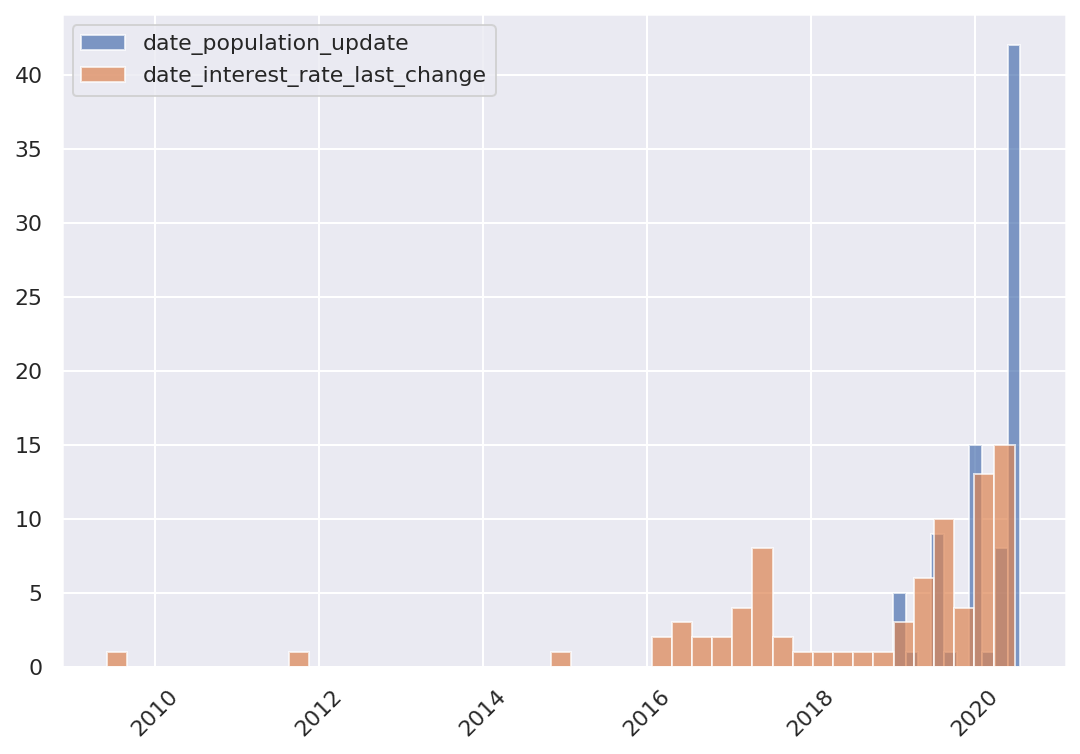

In [149]:
# Plot the distribution of each date column

col = 'date_population_update'
df[col].hist(
    bins=10, alpha=0.7, label=col
)

col = 'date_interest_rate_last_change'
df[col].hist(
    bins=45, alpha=0.7, label=col
)

plt.xticks(rotation=45)
plt.legend()

plt.savefig(
    '../figures/chapter-6-country-update-dates.png',
    bbox_inches='tight',
    dpi=300,
)

In [150]:
# What country has the oldest date since last interest rate change?

min_date = df['date_interest_rate_last_change'].min()
min_date_mask = df['date_interest_rate_last_change'] == min_date
df[min_date_mask]

,country,population,population_pct,date_population_update,interest_rate_pct,date_interest_rate_last_change,average_inflation_rate_pct
80,Barbados,287025.0,0.00368,2019-07-01,7.0,2009-06-01,1.67


In [151]:
# Do any countries have negative interest rates?

neg_rates_mask = df['interest_rate_pct'] < 0
df[neg_rates_mask][['country', 'interest_rate_pct']]

,country,interest_rate_pct
9,Japan,-0.10
51,Switzerland,-0.75
58,Denmark,-0.75


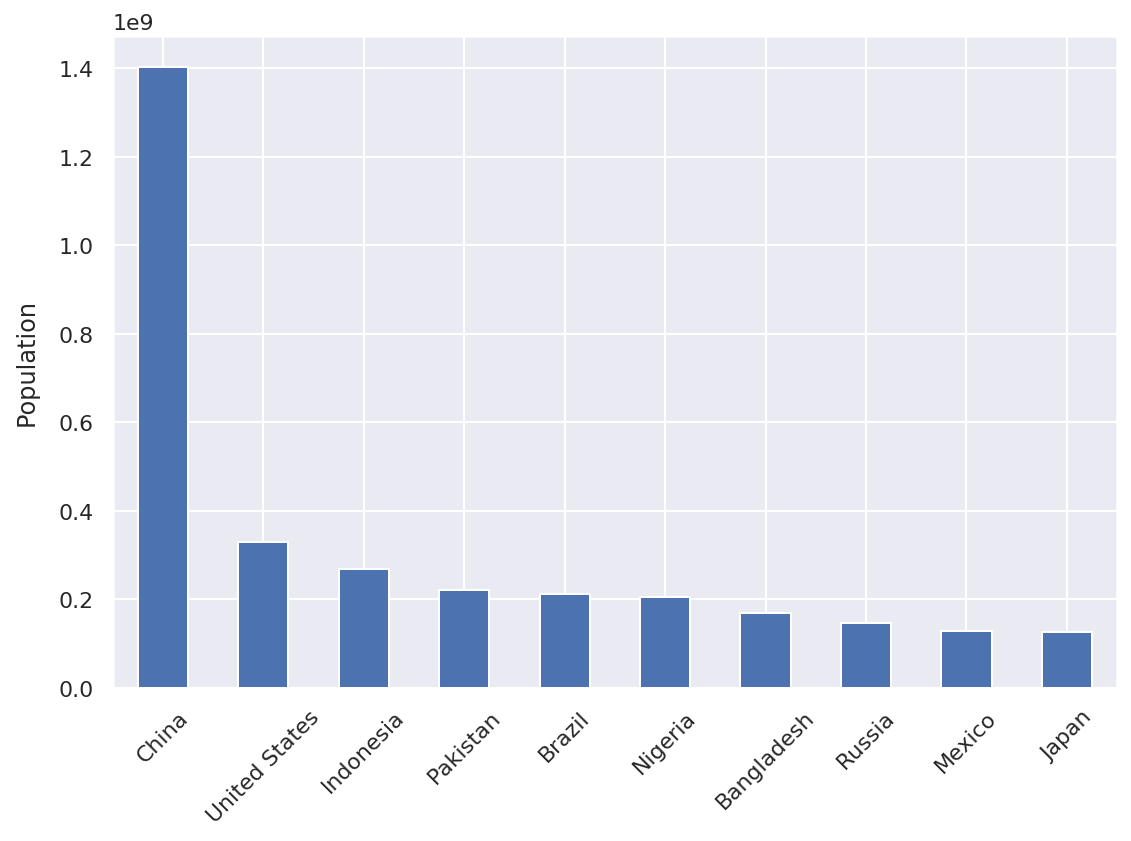

In [152]:
# Plot a bar chart of the top countries by population

df_plot = df.sort_values('population', ascending=False).head(10)

df_plot['population'].plot.bar()

plt.xticks(rotation=45)
plt.ylabel('Population')

ax = plt.gca()
labels = df_plot['country'].values
ax.set_xticklabels(labels)

plt.savefig(
    '../figures/chapter-6-country-top-populations.png',
    bbox_inches='tight',
    dpi=300,
)

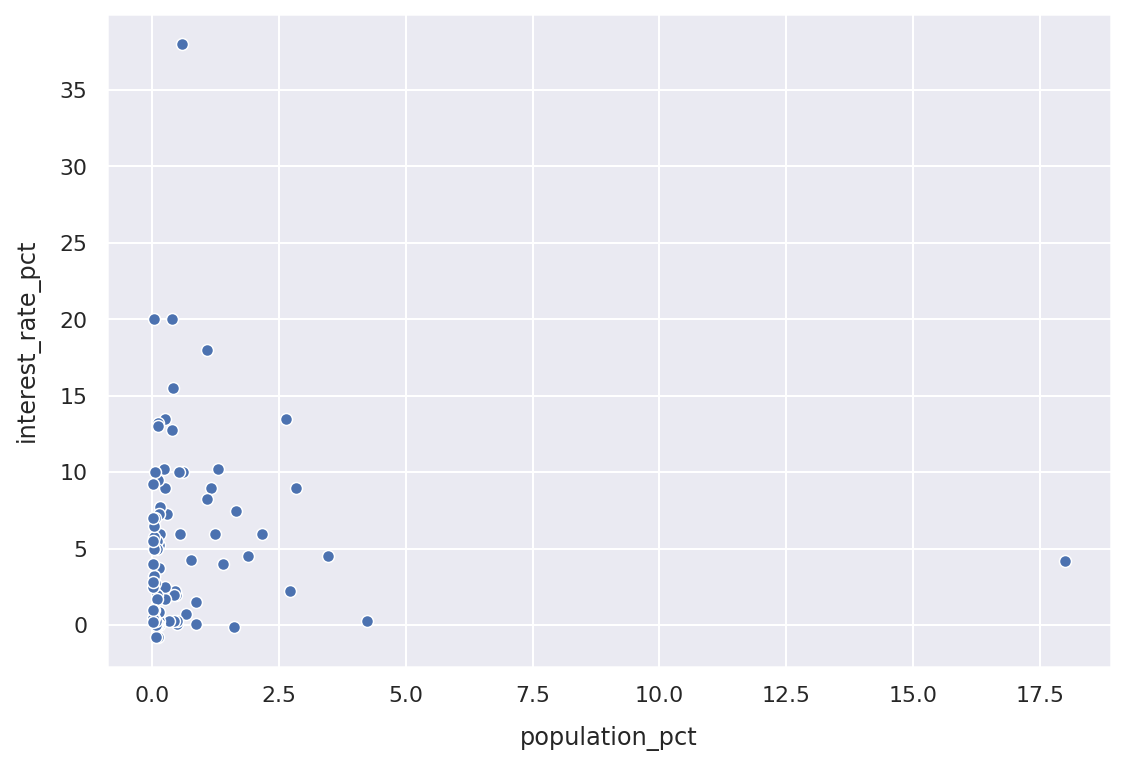

In [153]:
# Plot a scatter chart of population_pct VS interest_rate_pct

sns.scatterplot(data=df, x='population_pct', y='interest_rate_pct')
plt.show()

In [154]:
# Can you see any outliers along the population axis, above? What are they?

df[df['population_pct'] > 15]

,country,population,population_pct,date_population_update,interest_rate_pct,date_interest_rate_last_change,average_inflation_rate_pct
0,China,1.403613e+09,18.0,2020-07-20,4.2,2019-09-20,1.93


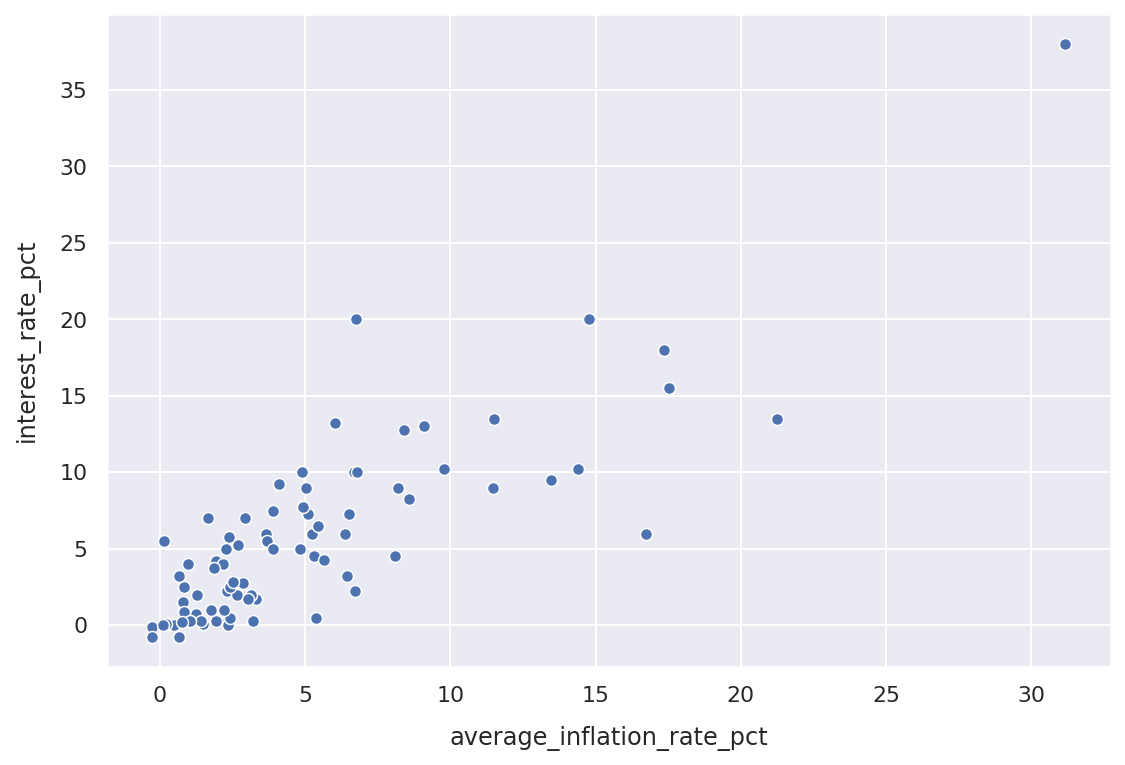

In [155]:
# Plot a scatter chart of average_inflation_rate_pct VS interest_rate_pct

sns.scatterplot(data=df, x='average_inflation_rate_pct', y='interest_rate_pct')
plt.show()

In [156]:
# Prep data for clustering algorithm

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features = ['population_pct', 'interest_rate_pct', 'average_inflation_rate_pct']
X = df[features].values
X_scaled = scaler.fit_transform(X)

df['scaled_population_pct'] = X_scaled[:,0]
df['scaled_interest_rate_pct'] = X_scaled[:,1]
df['scaled_average_inflation_rate_pct'] = X_scaled[:,2]

In [157]:
df.head()

,country,population,population_pct,date_population_update,interest_rate_pct,date_interest_rate_last_change,average_inflation_rate_pct,scaled_population_pct,scaled_interest_rate_pct,scaled_average_inflation_rate_pct
0,China,1.403613e+09,18.00,2020-07-20,4.20,2019-09-20,1.93,8.258554,-0.233071,-0.581368
1,United States,3.299857e+08,4.23,2020-07-20,0.25,2020-05-06,2.33,1.662005,-0.885604,-0.507121
2,Indonesia,2.696034e+08,3.46,2020-07-01,4.50,2020-03-19,5.29,1.293135,-0.183511,0.042307
3,Pakistan,2.208923e+08,2.83,2020-07-01,9.00,2020-04-17,5.03,0.991332,0.559881,-0.005953
4,Brazil,2.118177e+08,2.72,2020-07-20,2.25,2020-06-17,6.73,0.938636,-0.555207,0.309597


In [158]:
# Train a clustering model with 5 groups, on the scaled features above

from sklearn.cluster import KMeans
KMeans?

In [159]:
clf = KMeans(n_clusters=5)
clf.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

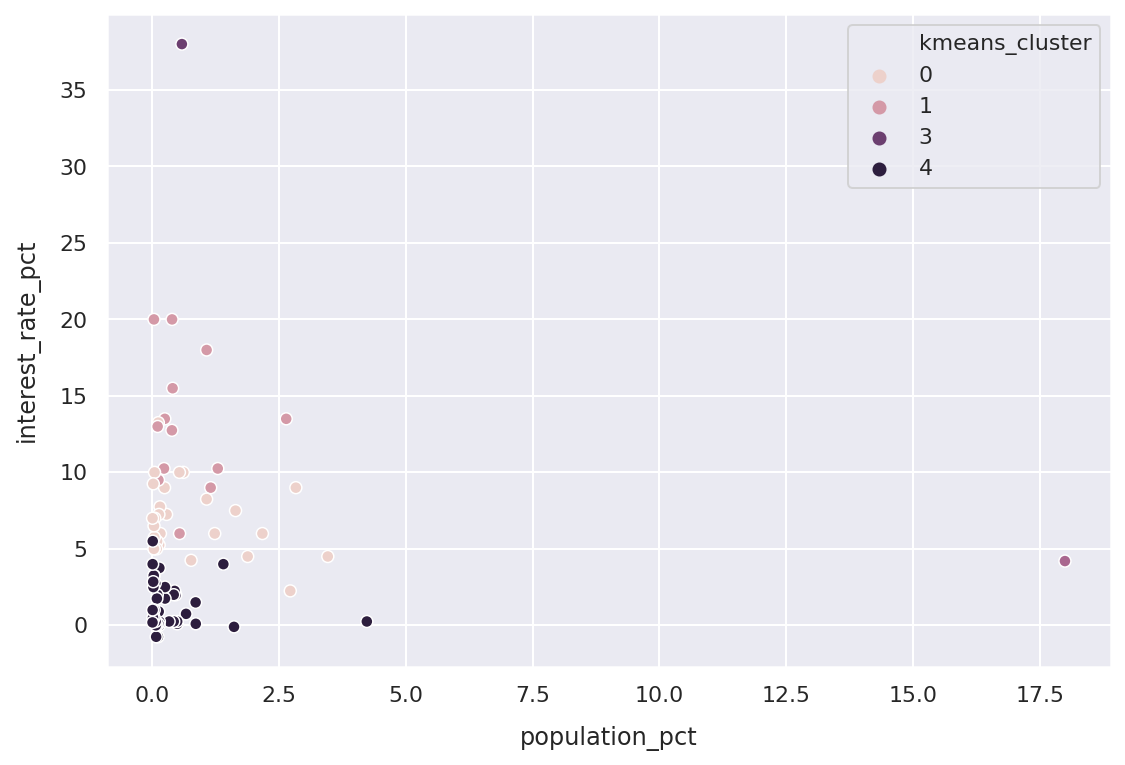

In [160]:
# Plot a scatter chart of population_pct VS interest_rate_pct
# Label the points by color, according to their cluster

df['kmeans_cluster'] = clf.predict(X_scaled)
sns.scatterplot(
    data=df,
    x='population_pct',
    y='interest_rate_pct',
    hue='kmeans_cluster',
)
plt.show()

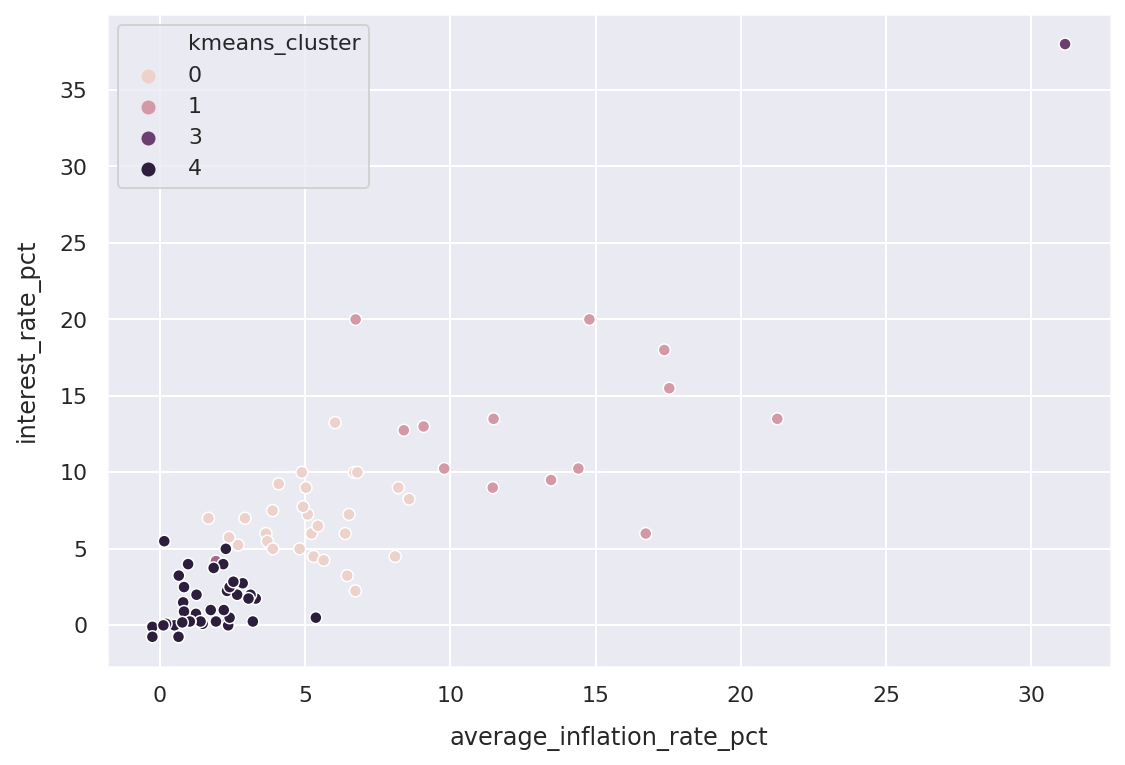

In [161]:
# Plot a scatter chart of average_inflation_rate_pct VS interest_rate_pct
# Label the points by color, according to their cluster

sns.scatterplot(
    data=df,
    x='average_inflation_rate_pct',
    y='interest_rate_pct',
    hue='kmeans_cluster',
)
plt.show()

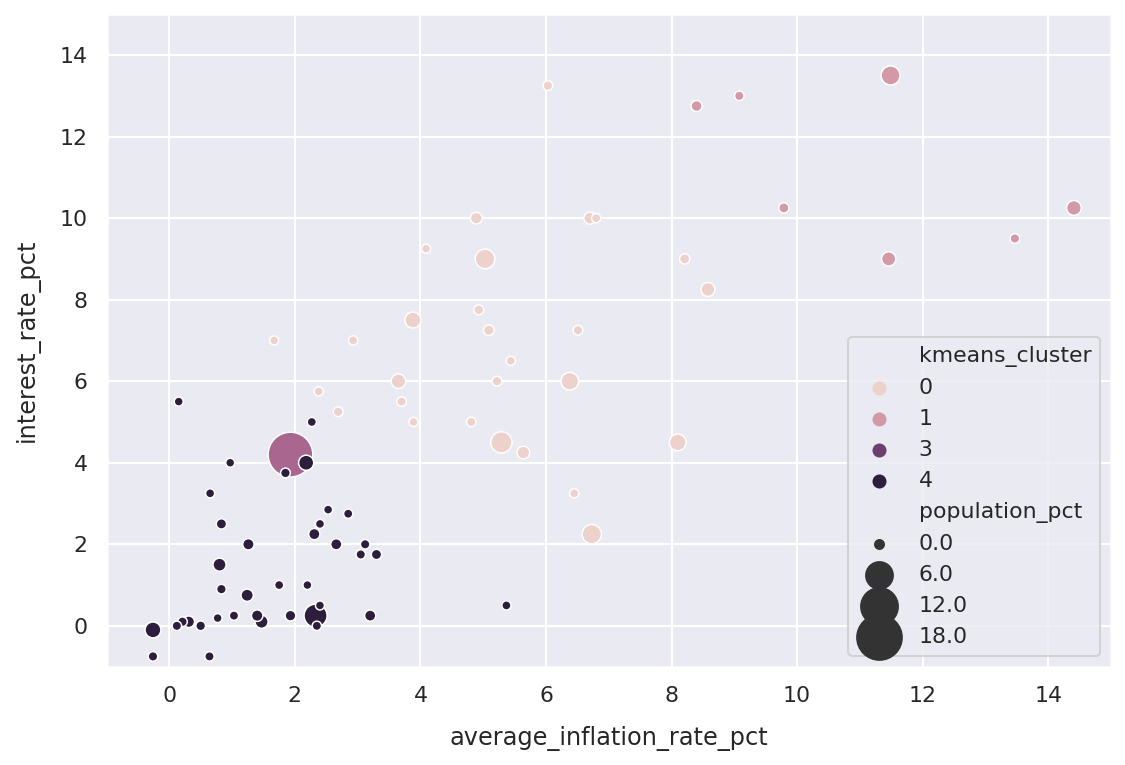

In [162]:
# Set point size according to population_pct on the above chart,
# and zoom in to see the majority of the points

sns.scatterplot(
    data=df,
    x='average_inflation_rate_pct',
    y='interest_rate_pct',
    size='population_pct',
    hue='kmeans_cluster',
    sizes=(20, 500),
)
plt.xlim(-1, 15)
plt.ylim(-1, 15)

plt.savefig(
    '../figures/chapter-6-country-kmeans-interest-inflation.png',
    bbox_inches='tight',
    dpi=300,
)

In [163]:
def render_3d_plot():
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = (9, 9)
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        df['interest_rate_pct'],
        df['average_inflation_rate_pct'],
        df['population_pct'],
        c=df['kmeans_cluster'].values,
    )
    ax.set_xlabel('interest_rate_pct')
    ax.set_ylabel('average_inflation_rate_pct')
    ax.set_zlabel('population_pct')

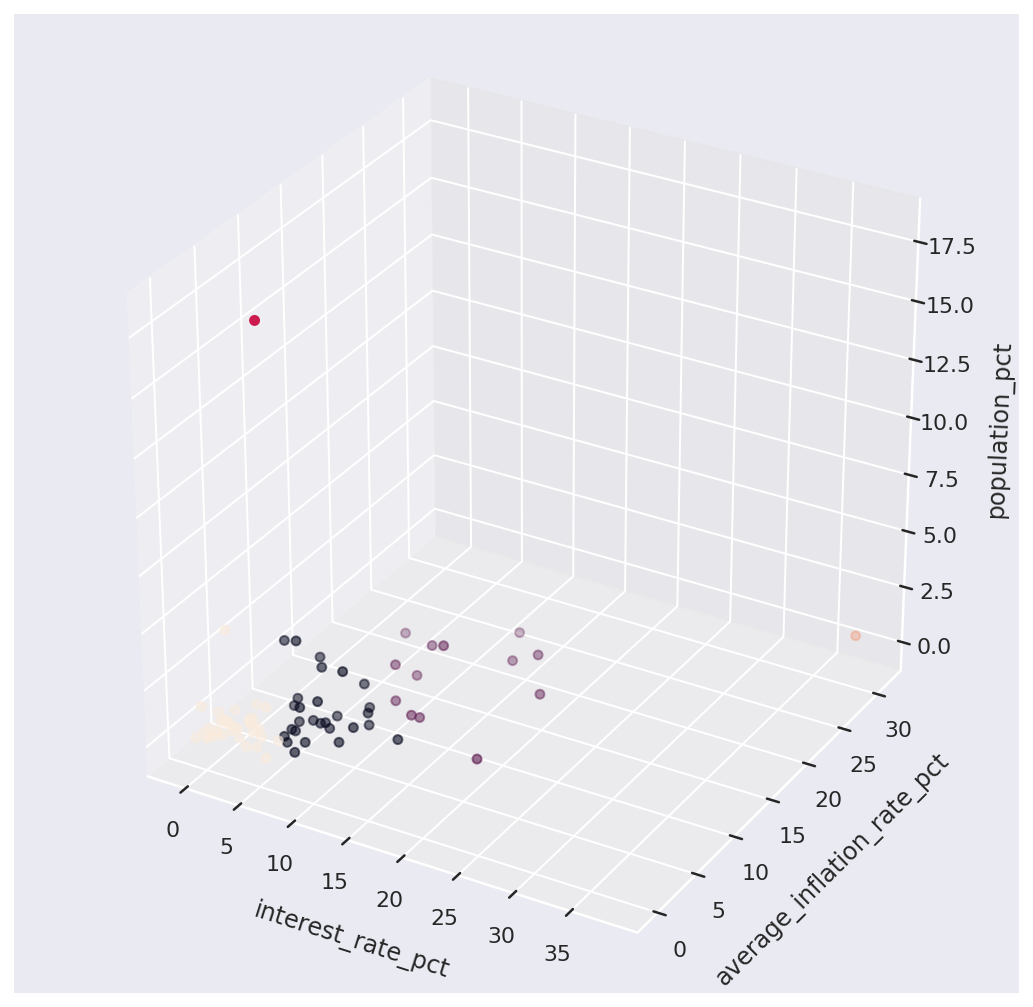

In [164]:
%matplotlib inline
render_3d_plot()

     |████████████████████████████████| 463 kB 5.1 MB/s eta 0:00:01


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

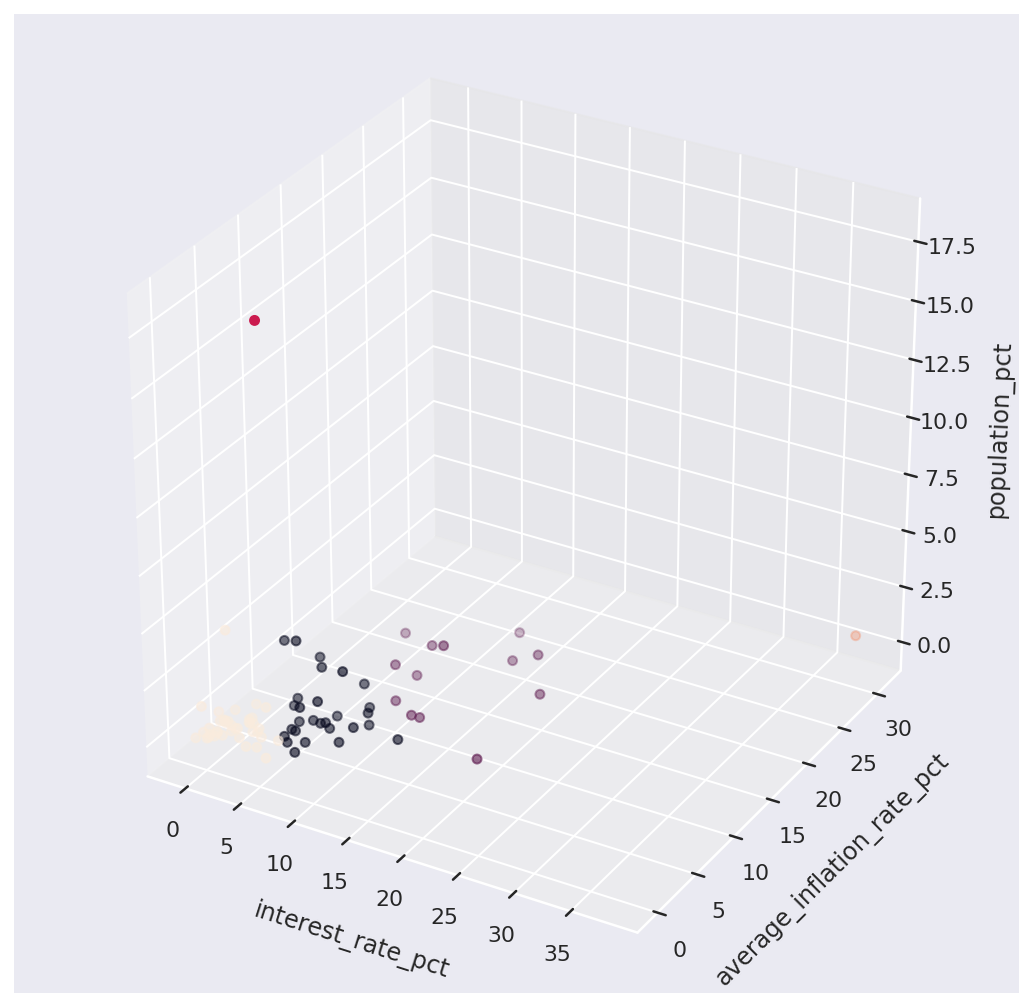

In [165]:
# Interactive plot (JupyterLab)
!pip install ipympl
%matplotlib ipympl
render_3d_plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

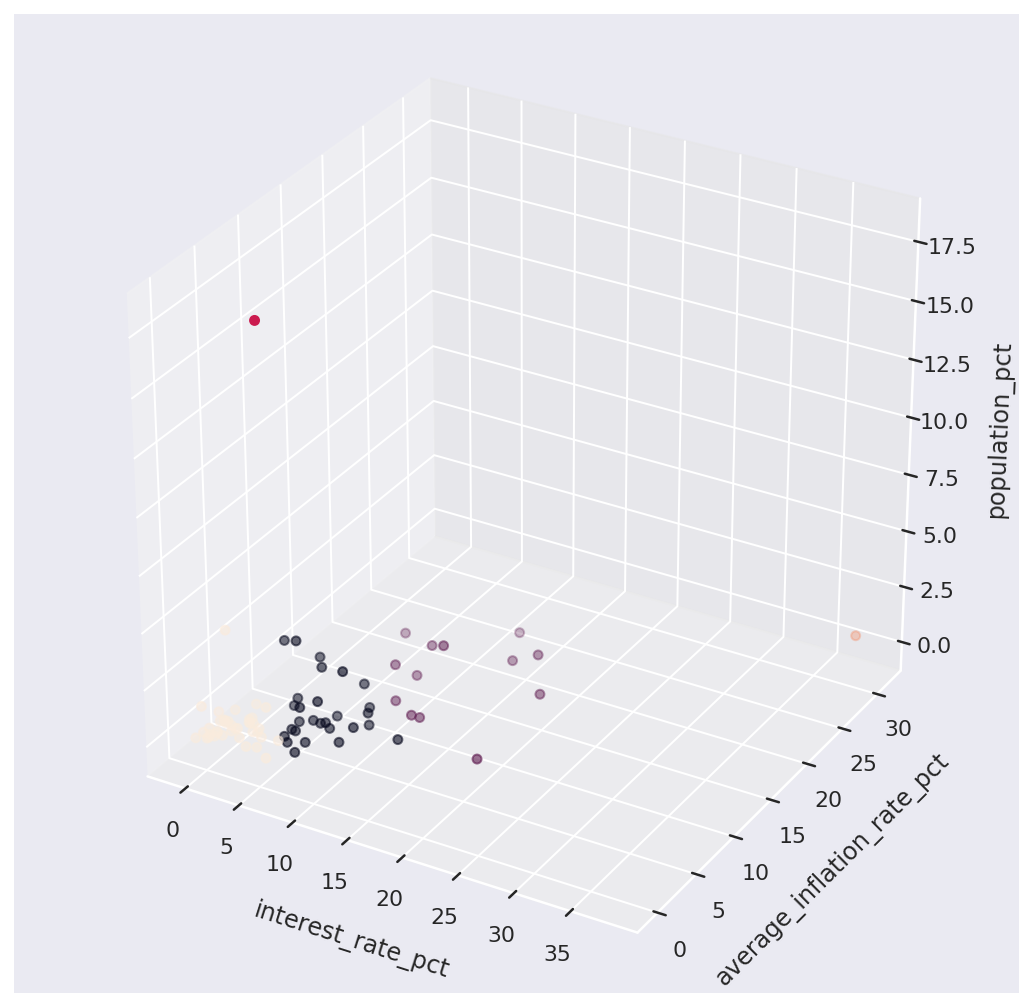

In [166]:
# Interactive plot (Jupyter Notebook only)
%matplotlib notebook
render_3d_plot()

In [167]:
# Save the clustering model

import joblib
joblib.dump(scaler, 'kmeans-5-cluster-scaler.pkl')
joblib.dump(clf, 'kmeans-5-cluster-model.pkl')

['kmeans-5-cluster-model.pkl']

In [168]:
!ls *.pkl

kmeans-5-cluster-model.pkl  kmeans-5-cluster-scaler.pkl
